In [1]:
SUBJECT = 1
BASE_DIR = "/tmp/akshett.jindal"
MODEL_ID = "llava-hf/llava-1.5-13b-hf"

In [2]:
MODEL_NAME = MODEL_ID.replace("/", "_").replace(" ", "_")

In [3]:
import os.path
import pickle

hidden_states_filepath = os.path.join(
    BASE_DIR,
    "image_embeddings",
    MODEL_NAME,
    f"subject_{SUBJECT:02}",
    "hidden_states.pkl"
)

with open(hidden_states_filepath, "rb") as f:
    HIDDEN_STATES = pickle.load(f)

HIDDEN_STATES.keys()

dict_keys(['hidden_states'])

In [4]:
from nsd_dataset import mind_eye_nsd_utils as menutils

(
    trial_order,
    session_data,
    (
        trn_stim_ordering, trn_voxel_data,
        val_stim_ordering, val_voxel_data
    )
) = menutils.get_split_data(BASE_DIR, SUBJECT, average_out_fmri=True)

Total number of voxels = 15724


In [5]:
print(f"{trial_order.shape = }, {trial_order.min() = }, {trial_order.max() = }")
print(f"{session_data.shape = }, {session_data.min() = }, {session_data.max() = }")
print(f"{trn_stim_ordering.shape = }, {trn_stim_ordering.min() = }, {trn_stim_ordering.max() = }")
print(f"{trn_voxel_data.shape = }, {trn_voxel_data.min() = }, {trn_voxel_data.max() = }")
print(f"{val_stim_ordering.shape = }, {val_stim_ordering.min() = }, {val_stim_ordering.max() = }")
print(f"{val_voxel_data.shape = }, {val_voxel_data.min() = }, {val_voxel_data.max() = }")

trial_order.shape = (10000,), trial_order.min() = 1, trial_order.max() = 10000
session_data.shape = (10000, 15724), session_data.min() = -32768.0, session_data.max() = 32767.0
trn_stim_ordering.shape = (9000,), trn_stim_ordering.min() = 1000, trn_stim_ordering.max() = 9999
trn_voxel_data.shape = (9000, 15724), trn_voxel_data.min() = -32768.0, trn_voxel_data.max() = 32767.0
val_stim_ordering.shape = (1000,), val_stim_ordering.min() = 0, val_stim_ordering.max() = 999
val_voxel_data.shape = (1000, 15724), val_voxel_data.min() = -28514.333333333332, val_voxel_data.max() = 32767.0


In [6]:
print(f"{session_data.shape = }")
print(f"{trn_stim_ordering.shape = }")
print(f"{trn_voxel_data.shape = }")
print(f"{val_stim_ordering.shape = }")
print(f"{val_voxel_data.shape = }")

session_data.shape = (10000, 15724)
trn_stim_ordering.shape = (9000,)
trn_voxel_data.shape = (9000, 15724)
val_stim_ordering.shape = (1000,)
val_voxel_data.shape = (1000, 15724)


In [7]:
from nsd_dataset import mind_eye_nsd_utils as menutils

exp_design = menutils.load_exp_design_file(BASE_DIR)

trial_images = exp_design["subjectim"]
trial_images

array([[ 2951,  2991,  3050, ..., 19472, 49508, 11124],
       [ 2951,  2991,  3050, ..., 29015, 40443,  7566],
       [ 2951,  2991,  3050, ..., 40627, 60549, 60491],
       ...,
       [ 2951,  2991,  3050, ..., 22828, 64982, 39213],
       [ 2951,  2991,  3050, ..., 68368, 68973, 16416],
       [ 2951,  2991,  3050, ..., 24254, 14948, 42093]], dtype=int32)

In [8]:
trn_images = trial_images[SUBJECT-1, trn_stim_ordering] - 1
val_images = trial_images[SUBJECT-1, val_stim_ordering] - 1

trn_images.shape, trn_images.min(), trn_images.max()

((9000,), 13, 72999)

In [9]:
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")
backend

<module 'himalaya.backend.torch_cuda' from '/home2/akshett.jindal/miniconda3/envs/subba/lib/python3.10/site-packages/himalaya/backend/torch_cuda.py'>

In [10]:
import numpy

alphas = numpy.logspace(1, 3, 50)
alphas

array([  10.        ,   10.98541142,   12.06792641,   13.25711366,
         14.56348478,   15.9985872 ,   17.57510625,   19.30697729,
         21.20950888,   23.29951811,   25.59547923,   28.11768698,
         30.88843596,   33.93221772,   37.2759372 ,   40.94915062,
         44.98432669,   49.41713361,   54.28675439,   59.63623317,
         65.51285569,   71.9685673 ,   79.06043211,   86.85113738,
         95.40954763,  104.81131342,  115.13953993,  126.48552169,
        138.94954944,  152.64179672,  167.68329368,  184.20699693,
        202.35896477,  222.29964825,  244.20530945,  268.26957953,
        294.70517026,  323.74575428,  355.64803062,  390.69399371,
        429.19342601,  471.48663635,  517.94746792,  568.9866029 ,
        625.05519253,  686.648845  ,  754.31200634,  828.64277285,
        910.29817799, 1000.        ])

In [11]:
from himalaya.ridge import RidgeCV
import numpy
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

def train_model(hidden_states):
    pipelines = []

    num_hidden_layers = 0
    for i in hidden_states.values():
        num_hidden_layers = len(i)
        break

    for layer_num in tqdm(range(num_hidden_layers)):
        trn_hs = numpy.array([
            hidden_states[image_id+1][layer_num]
            for image_id in trn_images
        ])
        val_hs = numpy.array([
            hidden_states[image_id+1][layer_num]
            for image_id in val_images
        ])

        ridge_cv = RidgeCV(
            alphas=alphas,
            solver_params=dict(
                n_targets_batch=500,
                n_alphas_batch=10,
                n_targets_batch_refit=100,
            )
        )
        pipeline = make_pipeline(ridge_cv)
        _ = pipeline.fit(trn_hs, trn_voxel_data)

        trn_scores = backend.to_numpy(pipeline.score(trn_hs, trn_voxel_data))
        val_scores = backend.to_numpy(pipeline.score(val_hs, val_voxel_data))

        del trn_hs
        del val_hs

        pipelines.append({
            "model": pipeline,
            "trn_scores": trn_scores,
            "val_scores": val_scores,
        })

    return pipelines

In [12]:
from himalaya.viz import plot_alphas_diagnostic
from matplotlib import pyplot

def plot_alpha_scores(pipelines):
    for layer_num, p in enumerate(pipelines):
        pipeline = p["model"]
        best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
        plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
        pyplot.title(f"Layer {layer_num:02}")
        pyplot.show()

key = 'hidden_states'


  0%|          | 0/41 [00:00<?, ?it/s]

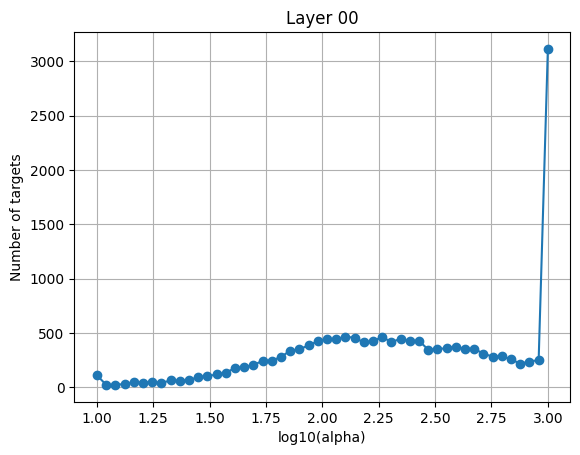

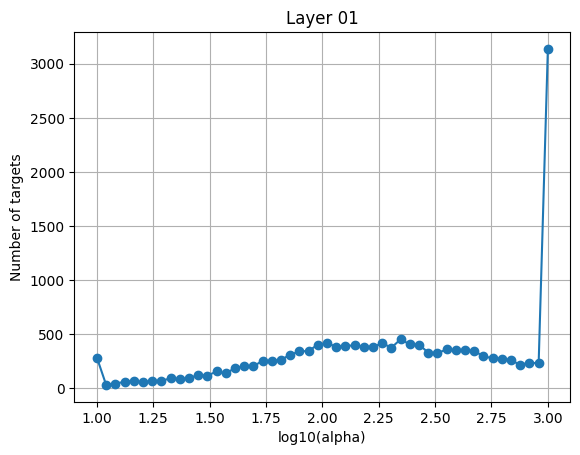

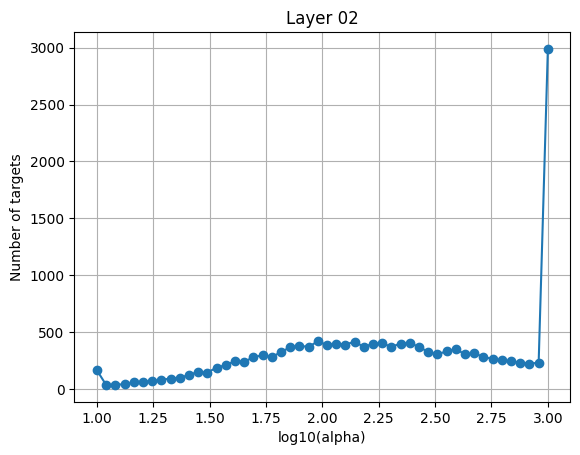

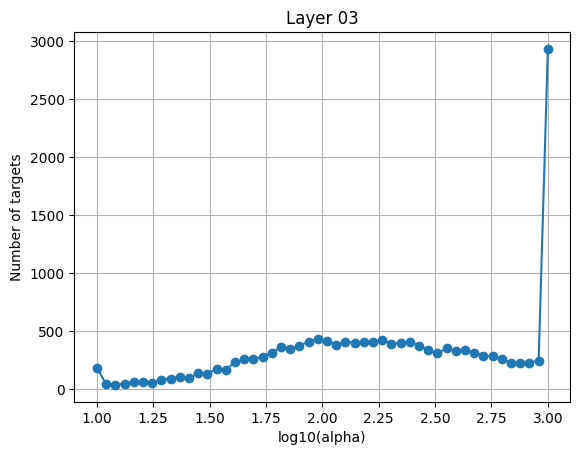

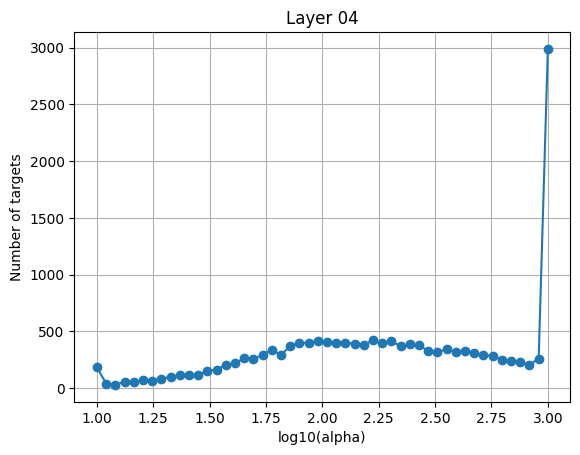

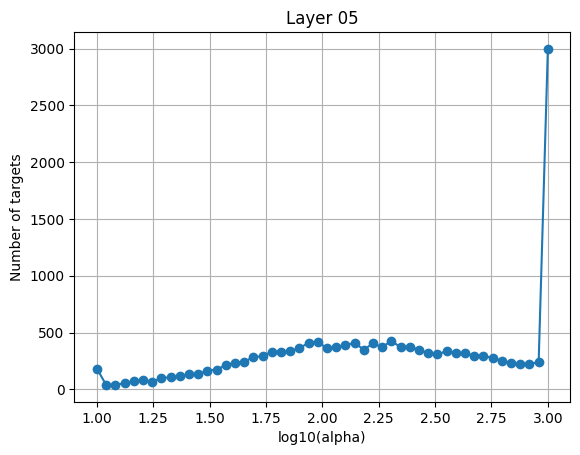

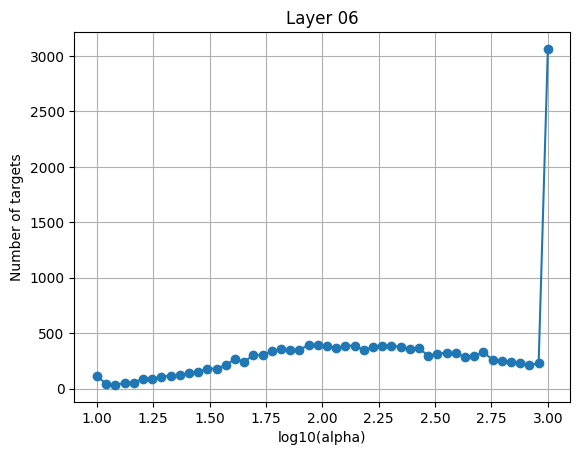

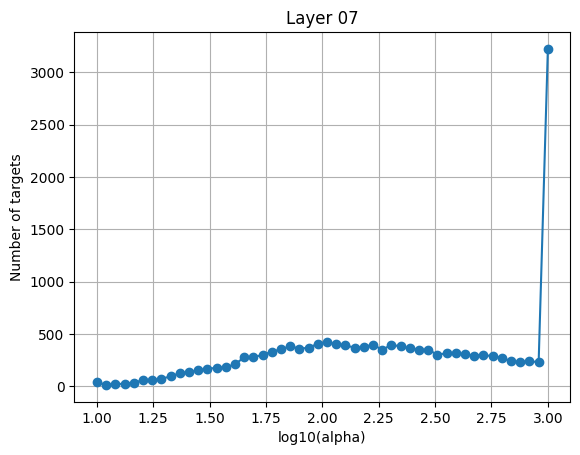

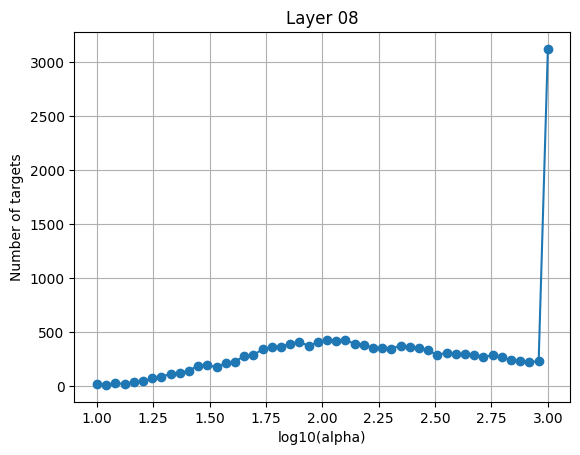

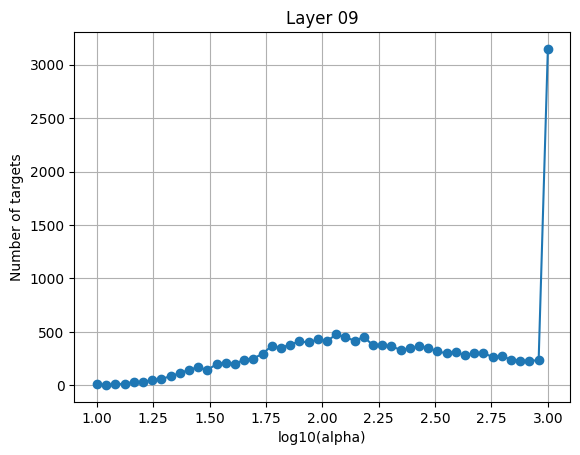

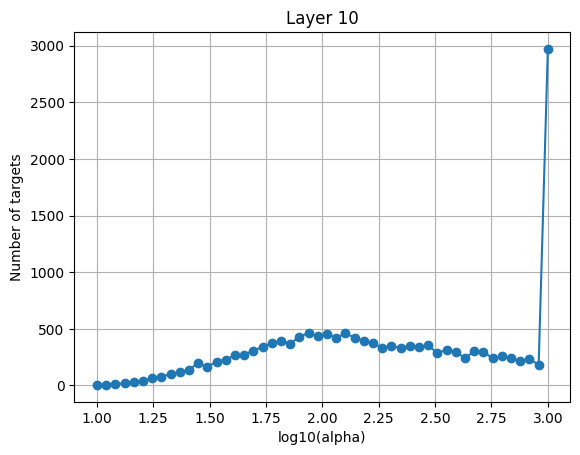

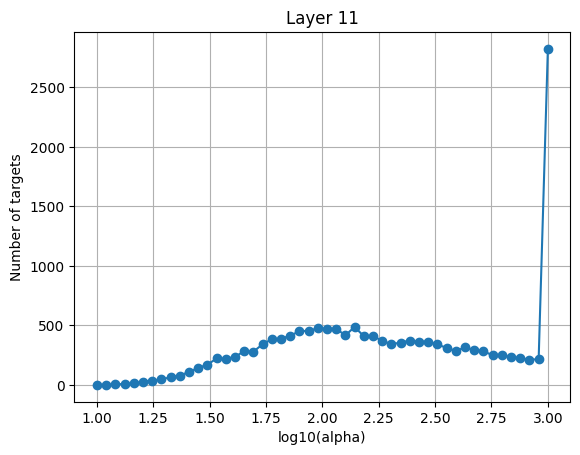

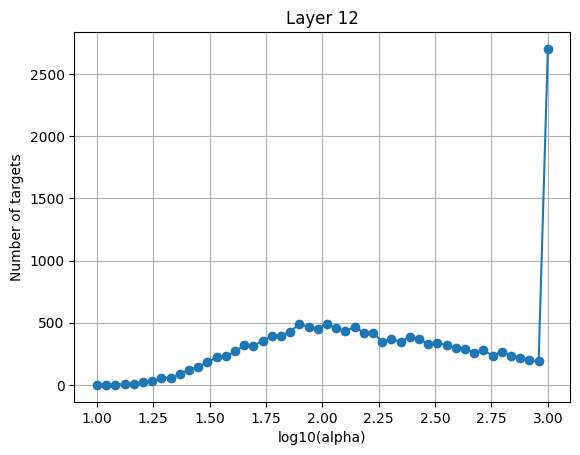

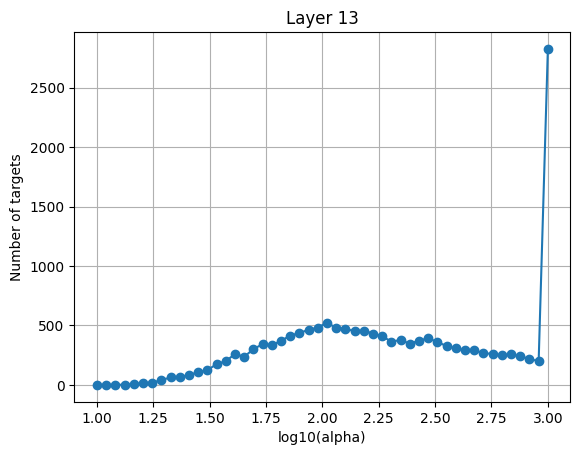

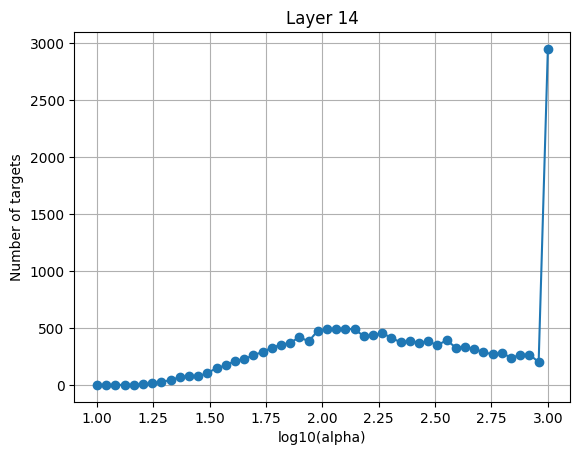

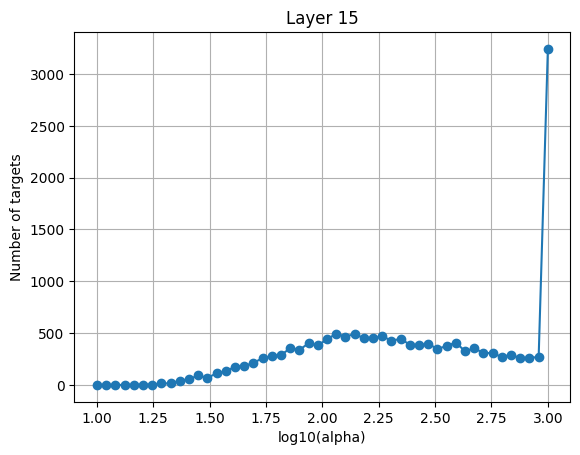

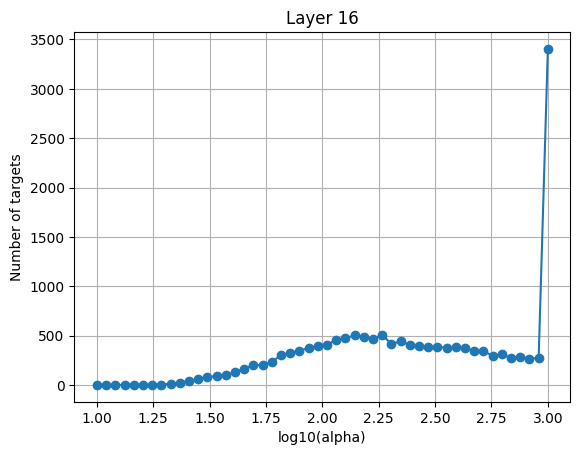

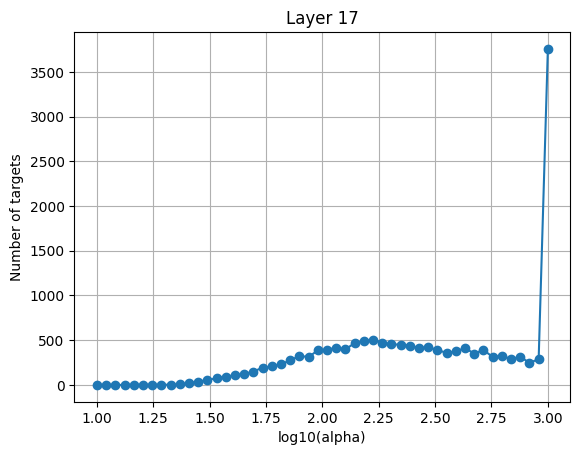

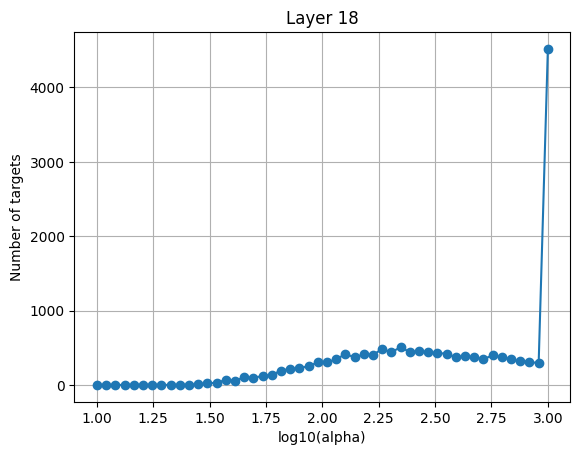

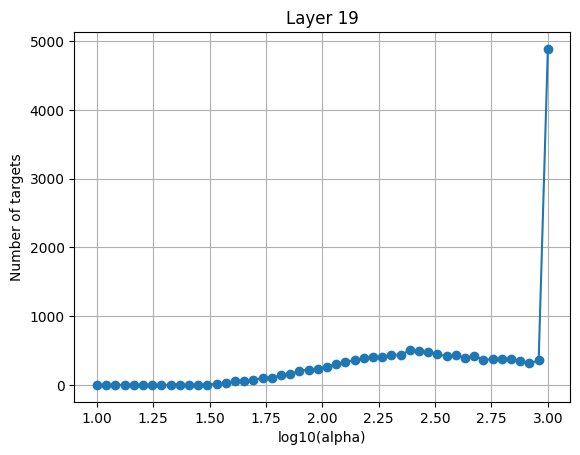

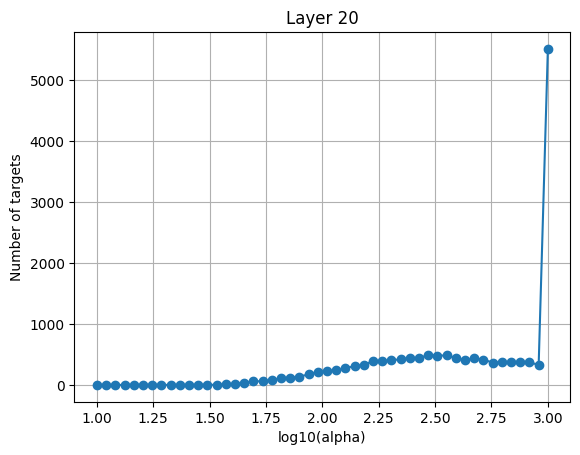

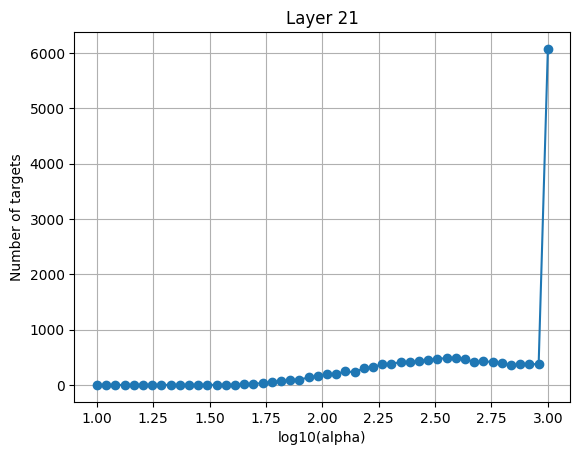

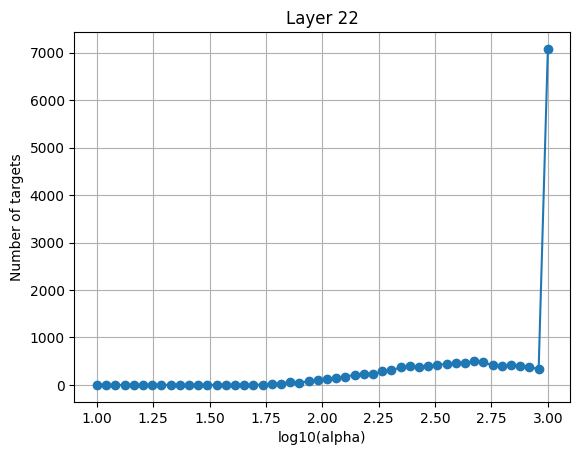

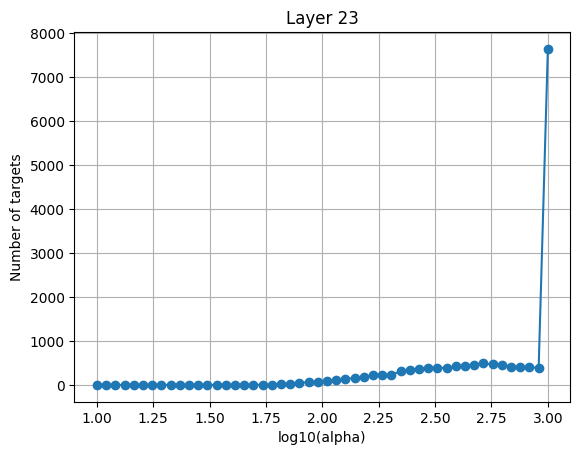

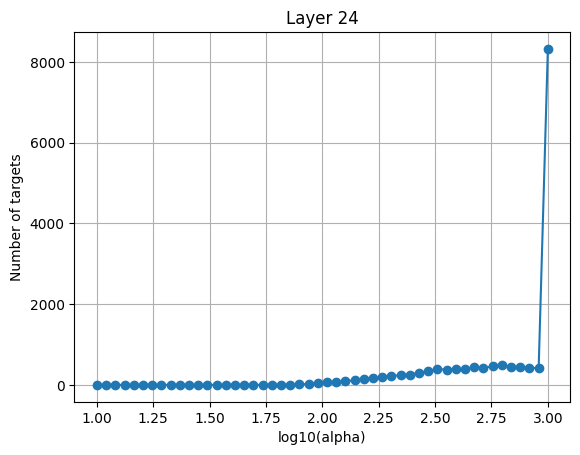

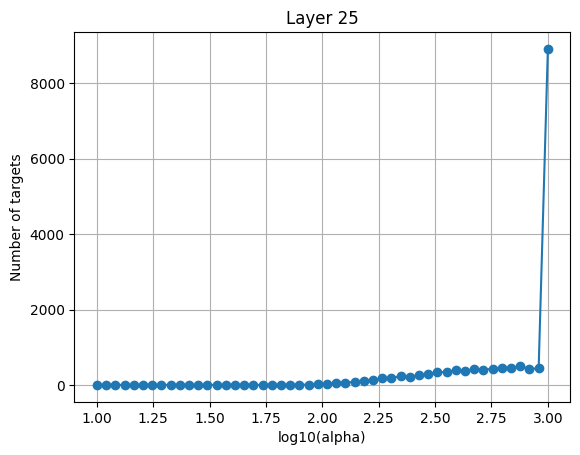

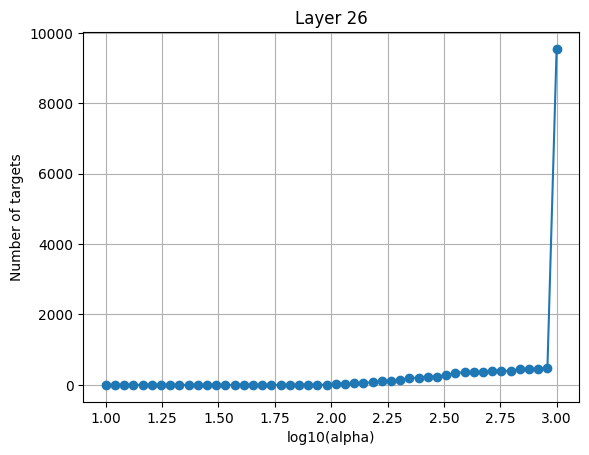

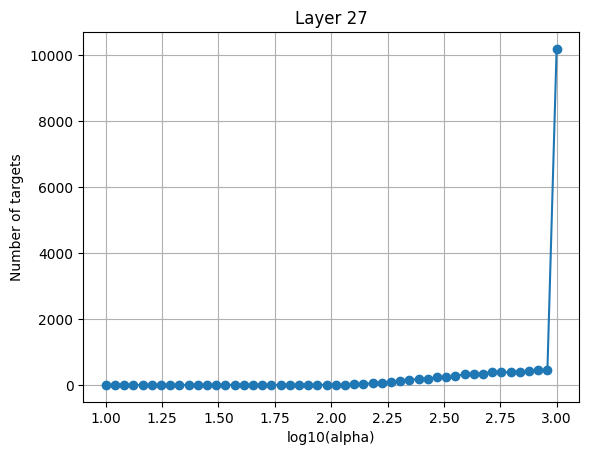

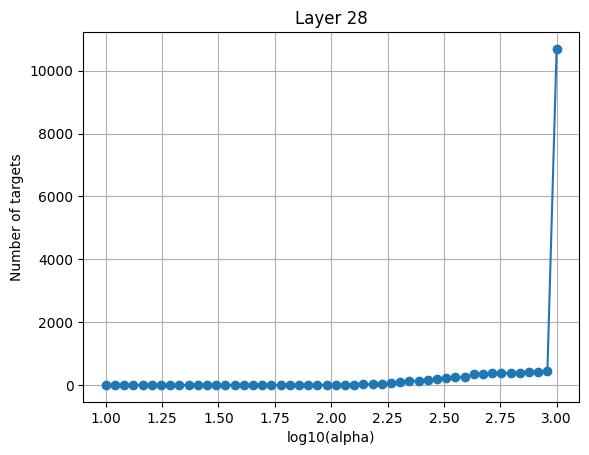

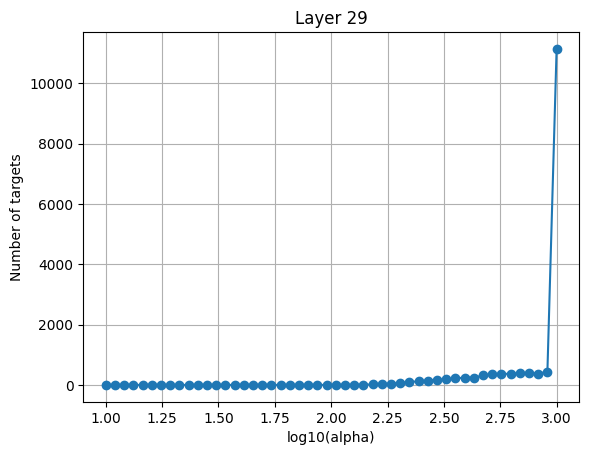

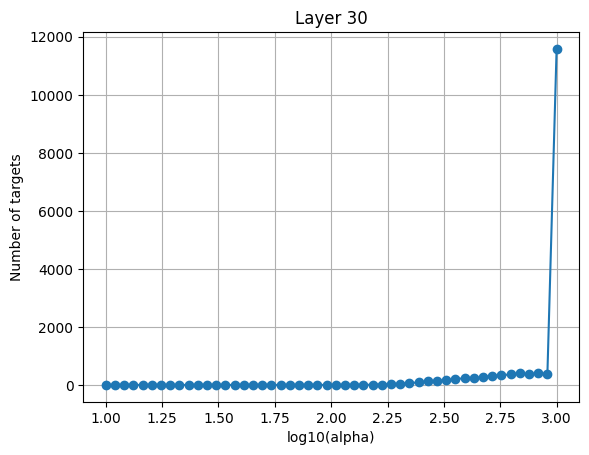

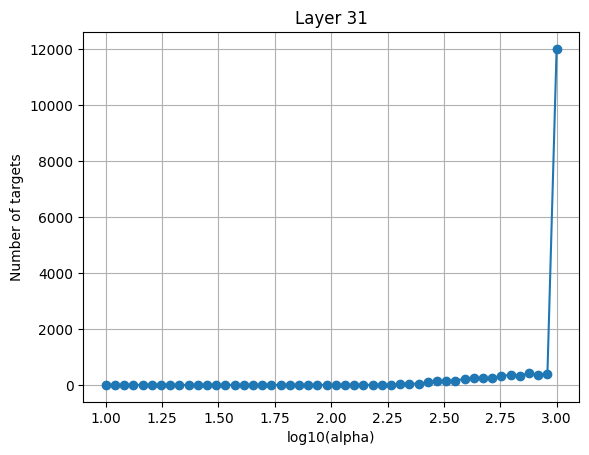

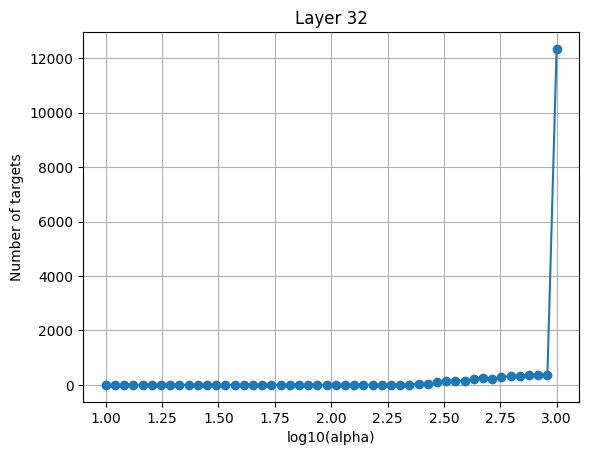

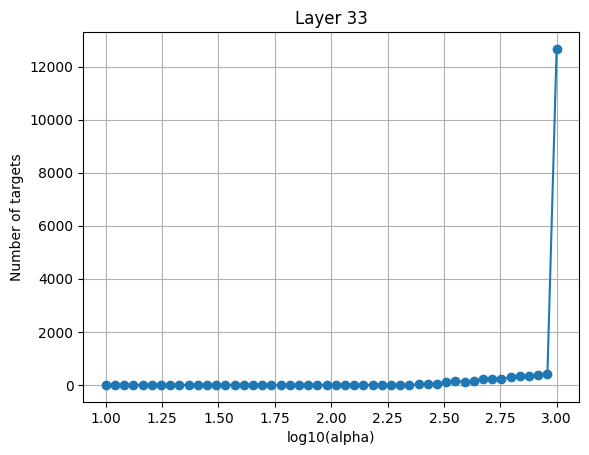

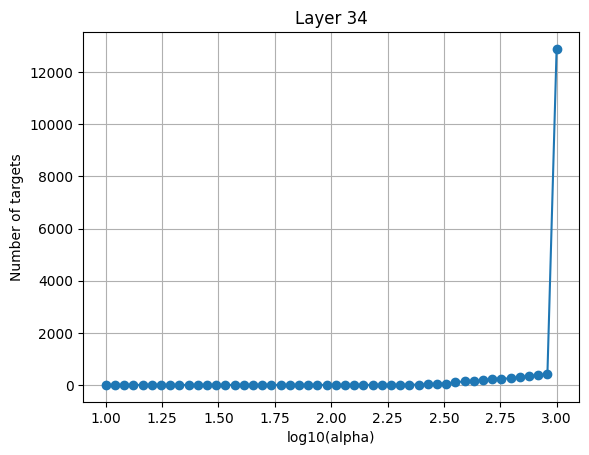

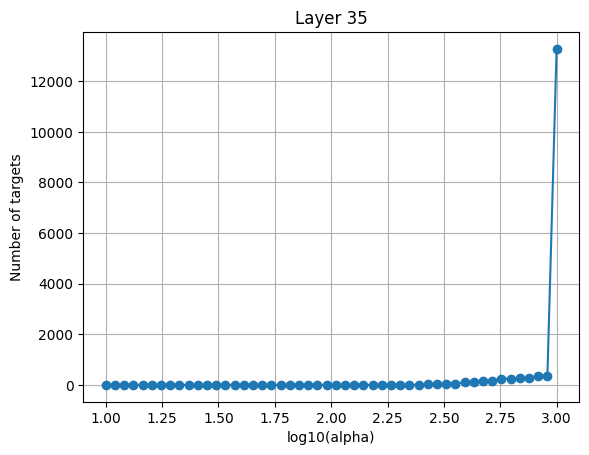

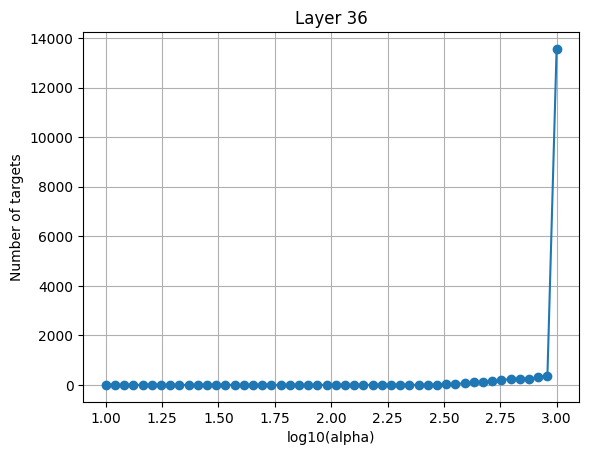

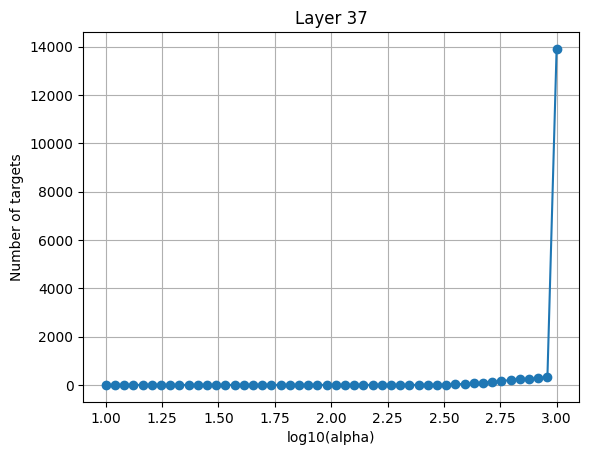

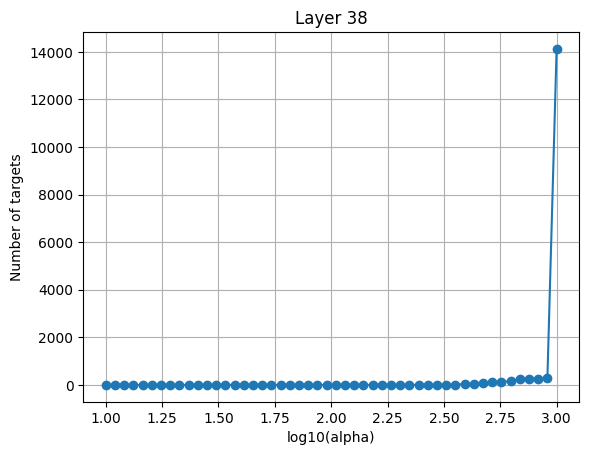

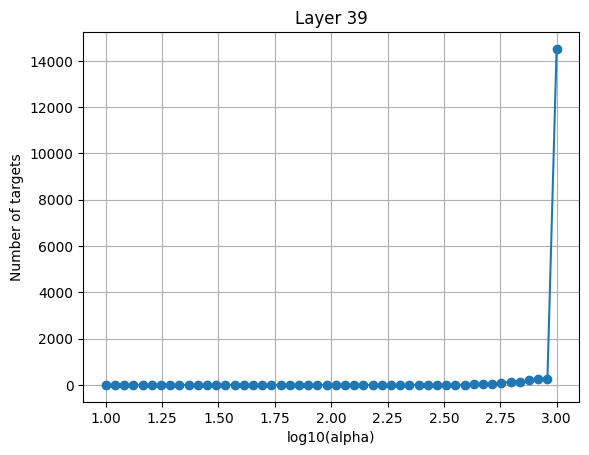

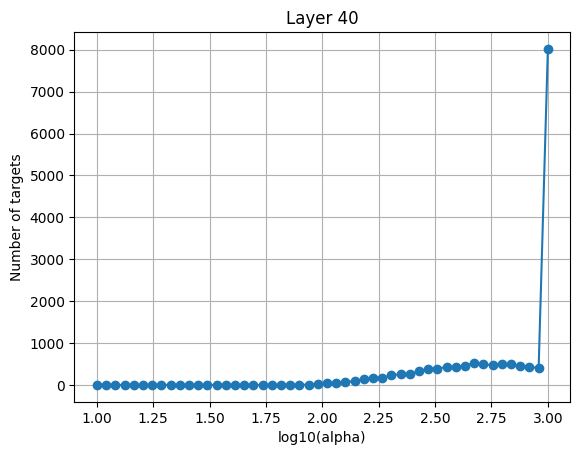

In [13]:
PIPELINES = {}

for key in HIDDEN_STATES.keys():
    print(f"{key = }")
    pipelines = train_model(HIDDEN_STATES[key])
    plot_alpha_scores(pipelines)
    PIPELINES[key] = pipelines

In [14]:
from nsd_dataset import mind_eye_nsd_utils as menutils

roi_masks = menutils.load_roi_masks(BASE_DIR, SUBJECT)
roi_masks.keys()

dict_keys(['prf-eccrois', 'corticalsulc', 'floc-faces', 'Kastner2015', 'streams', 'floc-bodies', 'thalamus', 'HCP_MMP1', 'nsdgeneral', 'MTL', 'prf-visualrois', 'floc-words', 'floc-places'])

In [18]:
import numpy

brain_mask = roi_masks["nsdgeneral"]

voxels = numpy.where(brain_mask == 1)
voxels

(array([12, 12, 12, ..., 72, 72, 72]),
 array([21, 22, 22, ..., 30, 30, 31]),
 array([47, 45, 46, ..., 46, 49, 49]))

In [19]:
import numpy

brain = numpy.zeros_like(brain_mask)
brain.shape

(81, 104, 83)

In [32]:
import numpy

TRN_SCORES = {}
VAL_SCORES = {}

for key in HIDDEN_STATES.keys():
    trn_scores = None
    val_scores = None

    for stats in PIPELINES[key]:
        trn_score = stats["trn_scores"]
        val_score = stats["val_scores"]

        if trn_scores is None:
            trn_scores = numpy.array([trn_score])
        else:
            trn_scores = numpy.concatenate((trn_scores, [trn_score]), axis=0)
        if val_scores is None:
            val_scores = numpy.array([val_score])
        else:
            val_scores = numpy.concatenate((val_scores, [val_score]), axis=0)

    trn_scores = numpy.average(trn_scores, axis=0)
    val_scores = numpy.average(val_scores, axis=0)

    roi_trn_scores = {}
    roi_val_scores = {}

    brain[:] = 0
    brain[voxels[0], voxels[1], voxels[2]] = trn_scores
    for roi in roi_masks:
        if roi == "nsdgeneral":
            continue
        roi_mask = numpy.where(roi_masks[roi] == 1)
        roi_score = numpy.average(brain[roi_mask[0], roi_mask[1], roi_mask[2]])
        roi_trn_scores[roi] = roi_score

    brain[:] = 0
    brain[voxels[0], voxels[1], voxels[2]] = val_scores
    for roi in roi_masks:
        if roi == "nsdgeneral":
            continue
        roi_mask = numpy.where(roi_masks[roi] == 1)
        roi_score = numpy.average(brain[roi_mask[0], roi_mask[1], roi_mask[2]])
        roi_val_scores[roi] = roi_score

    TRN_SCORES[key] = roi_trn_scores
    VAL_SCORES[key] = roi_val_scores

TRN_SCORES, VAL_SCORES

({'hidden_states': {'prf-eccrois': 0.12681338102308778,
   'corticalsulc': 0.0,
   'floc-faces': 0.1660221316340104,
   'Kastner2015': 0.15538676831783368,
   'streams': 0.16547097195520966,
   'floc-bodies': 0.24553259740480465,
   'thalamus': 0.0,
   'HCP_MMP1': 0.09425239090547449,
   'MTL': 0.0,
   'prf-visualrois': 0.23495616267751965,
   'floc-words': 0.14258765479838797,
   'floc-places': 0.2159357294255277}},
 {'hidden_states': {'prf-eccrois': 0.03883276434166793,
   'corticalsulc': 0.0,
   'floc-faces': 0.08161151711472382,
   'Kastner2015': 0.08949710027238482,
   'streams': 0.09010981681720254,
   'floc-bodies': 0.1837402002651841,
   'thalamus': 0.0,
   'HCP_MMP1': 0.0500427596814041,
   'MTL': 0.0,
   'prf-visualrois': 0.15287539031513875,
   'floc-words': 0.05582702135861523,
   'floc-places': 0.14938042402047652}})

In [33]:
import json
import os
import os.path

OUTPUT_DIR = os.path.join(BASE_DIR, "final_scores", MODEL_NAME, f"subj{SUBJECT:02}")
os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(os.path.join(OUTPUT_DIR, "training.json"), "w") as f:
    json.dump(TRN_SCORES, f, indent="    ")
with open(os.path.join(OUTPUT_DIR, "validation.json"), "w") as f:
    json.dump(VAL_SCORES, f, indent="    ")